In [42]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

import re


import os
from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, hamming_loss, accuracy_score
from sklearn.metrics import f1_score


import torch
from torch import nn
from transformers import BertForSequenceClassification, BertTokenizer, TrainingArguments, Trainer
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, Dataset

**BERT** is a pre trained language model that understands text by looking at context in both directions (left and right). Its success comes from learning two key tasks during training:<br>
**Fill in the-blank** : Predicting masked words in sentences (Masked Language Modeling).<br>
**Sentence flow** : Guessing if one sentence naturally follows another (Next Sentence Prediction).<br>
This helps BERT grasp nuances in language, making it great for tasks like answering questions or checking logical connections between statements.

**BERT's Architecture**  is a multi-layer Transformer encoder. The base version has 12 layers, each with 12 attention heads.

**Tokenization :**
Words are split into smaller. Special tokens like CLS (start of sentence) and SEP (separator between sentences) are added.

**Embeddings**: Each token is converted into a numerical vector.

**The Magic of Self bAttention:**
At the heart of BERT is self attention , a system that lets each word look at all other words in the sentence to understand context

**How it works** : Each word creates a query, key ,and value.
Words with matching queries/keys gets higher attention.

Sources:[Hugging Face](https://huggingface.co/blog/bert-101#:~:text=The%20bidirectional%20methodology%20you%20did,Isn%E2%80%99t%20that%20neat)

[A Deep Dive into BERT's Attention Mechanism](https://www.analyticsvidhya.com/blog/2023/12/berts-attention-mechanism/#:~:text=match%20at%20L340%20taking%20the,k2)


**PyTorch Basic:**
Essential Elements:

Tensors: Arrays for computations, GPU compatible.<br>
Autograd: Automatic gradient computation.<br>
Neural Network Modules: Building blocks like nn.Linear.<br>
Optimizers: Update rules like SGD, Adam.<br>
Datasets and DataLoaders: Manage data loading.<br>


In [43]:
# Create a tensor
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
print(x)
print('Shape:', x.shape)

tensor([[1., 2.],
        [3., 4.]])
Shape: torch.Size([2, 2])


**Building Models with PyTorch**
PyTorch provide the torch.nn module to help build neural network layers and models. The core concept is the nn.Module which is a base class for all neural network modules.

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# load the data
df = pd.read_csv('/content/drive/MyDrive/second_assingment/Toxic/train.csv/train.csv')
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [46]:
df_test = pd.read_csv('/content/drive/MyDrive/second_assingment/Toxic/test.csv/test.csv')
df_test.head(5)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [47]:
# Drop id
df = df.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

In [48]:
print('Shape of Train dataset', df.shape)
print('Shape of test dataset', df_test.shape)

Shape of Train dataset (159571, 7)
Shape of test dataset (153164, 1)


In [49]:
# Check distribution of labels
label_counts = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].value_counts()
label_counts

toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0                143346
1      0             0        0       0       0                  5666
                     1        0       1       0                  3800
                                      0       0                  1758
                     0        0       1       0                  1215
       1             1        0       1       0                   989
       0             1        0       1       1                   618
0      0             1        0       0       0                   317
                     0        0       1       0                   301
1      1             1        0       1       1                   265
0      0             1        0       1       0                   181
1      1             1        0       0       0                   158
       0             0        0       0       1                   136
                                      1       1                   134
                     1        1       1       0                   131
                     0        1       0       0                   113
       1             1        1       1       0                    64
       0             1        1       1       1                    56
0      0             0        0       0       1                    54
1      1             0        0       0       0                    41
       0             1        0       0       1                    35
       1             1        1       1       1                    31
0      0             0        0       1       1                    28
                              1       0       0                    22
                     1        0       1       1                    18
1      0             0        1       1       0                    16
       1             0        0       1       0                    14
       0             1        1       0       0                    11
       1             0        1       0       0                    11
                              0       1       1                     7
       0             0        1       0       1                     7
       1             1        0       0       1                     6
                              1       0       0                     4
0      0             1        0       0       1                     3
                     0        1       1       0                     3
1      0             0        1       1       1                     3
       1             0        0       0       1                     3
0      0             1        1       1       0                     2
                                      0       0                     2
1      1             0        1       0       1                     1
                                      1       0                     1
Name: count, dtype: int64

In [50]:
# The most rows have zero value across all 6 labels,I will create a new column 'non-toxic' for those values.
df['non-toxic'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) == 0).astype(int)

In [51]:
# Check again distribution of labels
label_counts = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non-toxic']].value_counts()
label_counts

toxic  severe_toxic  obscene  threat  insult  identity_hate  non-toxic
0      0             0        0       0       0              1            143346
1      0             0        0       0       0              0              5666
                     1        0       1       0              0              3800
                                      0       0              0              1758
                     0        0       1       0              0              1215
       1             1        0       1       0              0               989
       0             1        0       1       1              0               618
0      0             1        0       0       0              0               317
                     0        0       1       0              0               301
1      1             1        0       1       1              0               265
0      0             1        0       1       0              0               181
1      1             1        0       0       0              0               158
       0             0        0       0       1              0               136
                                      1       1              0               134
                     1        1       1       0              0               131
                     0        1       0       0              0               113
       1             1        1       1       0              0                64
       0             1        1       1       1              0                56
0      0             0        0       0       1              0                54
1      1             0        0       0       0              0                41
       0             1        0       0       1              0                35
       1             1        1       1       1              0                31
0      0             0        0       1       1              0                28
                              1       0       0              0                22
                     1        0       1       1              0                18
1      0             0        1       1       0              0                16
       1             0        0       1       0              0                14
       0             1        1       0       0              0                11
       1             0        1       0       0              0                11
                              0       1       1              0                 7
       0             0        1       0       1              0                 7
       1             1        0       0       1              0                 6
                              1       0       0              0                 4
0      0             1        0       0       1              0                 3
                     0        1       1       0              0                 3
1      0             0        1       1       1              0                 3
       1             0        0       0       1              0                 3
0      0             1        1       1       0              0                 2
                                      0       0              0                 2
1      1             0        1       0       1              0                 1
                                      1       0              0                 1
Name: count, dtype: int64

**Now it looks nice.**

In [52]:
df.shape

(159571, 8)

In [53]:
# Labels are imblanced, the non-toxic label is 25 times more than the next most common label
# I will drop most of the non-toxic rows to help balance the dataset
df = df.drop(df[df['non-toxic'] == 1].sample(frac=0.95).index)
# to filter the rows randomly, I got the idea sample() Method from w3school:
# https://www.w3schools.com/python/pandas/ref_df_sample.asp

In [54]:
# Distribution of label
label_counts = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non-toxic']].value_counts()
label_counts

toxic  severe_toxic  obscene  threat  insult  identity_hate  non-toxic
0      0             0        0       0       0              1            7167
1      0             0        0       0       0              0            5666
                     1        0       1       0              0            3800
                                      0       0              0            1758
                     0        0       1       0              0            1215
       1             1        0       1       0              0             989
       0             1        0       1       1              0             618
0      0             1        0       0       0              0             317
                     0        0       1       0              0             301
1      1             1        0       1       1              0             265
0      0             1        0       1       0              0             181
1      1             1        0       0       0              0             158
       0             0        0       0       1              0             136
                                      1       1              0             134
                     1        1       1       0              0             131
                     0        1       0       0              0             113
       1             1        1       1       0              0              64
       0             1        1       1       1              0              56
0      0             0        0       0       1              0              54
1      1             0        0       0       0              0              41
       0             1        0       0       1              0              35
       1             1        1       1       1              0              31
0      0             0        0       1       1              0              28
                              1       0       0              0              22
                     1        0       1       1              0              18
1      0             0        1       1       0              0              16
       1             0        0       1       0              0              14
       0             1        1       0       0              0              11
       1             0        1       0       0              0              11
                              0       1       1              0               7
       0             0        1       0       1              0               7
       1             1        0       0       1              0               6
                              1       0       0              0               4
0      0             1        0       0       1              0               3
                     0        1       1       0              0               3
1      0             0        1       1       1              0               3
       1             0        0       0       1              0               3
0      0             1        1       1       0              0               2
                                      0       0              0               2
1      1             0        1       0       1              0               1
                                      1       0              0               1
Name: count, dtype: int64

In [55]:
# Resize the train dataset
df_test=  df_test.drop(df_test.sample(frac=0.99).index)


In [ ]:
print('Shape of train dataset', df.shape)
print('Shape of test dataset', df_test.shape)

Shape of trian dataset (23392, 8)
Shape of test dataset (1532, 1)


In [57]:
# The text is needed to be clean:
def clean(text):
    # HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Remove web links
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove special characters
    text = re.sub(r"[^a-zA-Z\s\-']", '', text)
    # Remove extra white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.lower()
# I got the code structure from lecture, but I modified it

In [58]:
# Applying the functin for train and test
df['comment_text'] = df['comment_text'].apply(clean)
df_test['comment_text'] = df_test['comment_text'].apply(clean)

In [59]:
# let's take a look to each comment category
toxic = df[df['toxic'] == 1]
toxic.head()


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non-toxic
6,cocksucker before you piss around on my work,1,1,1,0,1,0,0
12,hey what is it talk what is it an exclusive gr...,1,0,0,0,0,0,0
16,bye don't look come or think of comming back t...,1,0,0,0,0,0,0
42,you are gay or antisemmitian archangel white t...,1,0,1,0,1,1,0
43,fuck your filthy mother in the ass dry,1,0,1,0,1,0,0


In [60]:
severe_toxic = df[df['severe_toxic'] == 1]
severe_toxic.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non-toxic
6,cocksucker before you piss around on my work,1,1,1,0,1,0,0
55,stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0,0
181,you are a stupid fuck and your mother's cunt s...,1,1,1,0,1,0,0
442,hi im a fucking bitch,1,1,1,0,1,0,0
579,what a motherfucking piece of crap those fuckh...,1,1,1,0,1,0,0


In [61]:
obscene = df[df['obscene'] == 1]
obscene.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non-toxic
6,cocksucker before you piss around on my work,1,1,1,0,1,0,0
42,you are gay or antisemmitian archangel white t...,1,0,1,0,1,1,0
43,fuck your filthy mother in the ass dry,1,0,1,0,1,0,0
51,get fucked up get fuckeeed up got a drink that...,1,0,1,0,0,0,0
55,stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0,0


In [62]:
threat = df[df['threat'] == 1]
threat.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non-toxic
79,hi i am back again last warning stop undoing m...,1,0,0,1,0,0,0
176,i think that your a fagget get a oife and burn...,1,0,1,1,1,1,0
600,i'm also a sock puppet of this accountsuprise ...,1,0,0,1,0,0,0
802,fuck you smith please have me notified when yo...,1,0,1,1,1,0,0
1017,wouldn't be the first time bitch fuck you i'll...,1,1,1,1,1,1,0


In [63]:
insult = df[df['insult'] == 1]
insult.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non-toxic
6,cocksucker before you piss around on my work,1,1,1,0,1,0,0
42,you are gay or antisemmitian archangel white t...,1,0,1,0,1,1,0
43,fuck your filthy mother in the ass dry,1,0,1,0,1,0,0
55,stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0,0
56,tony sidaway is obviously a fistfuckee he love...,1,0,1,0,1,0,0


In [64]:
hate = df[df['identity_hate'] == 1]
hate.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non-toxic
42,you are gay or antisemmitian archangel white t...,1,0,1,0,1,1,0
105,a pair of jew-hating weiner nazi schmucks,1,0,1,0,1,1,0
176,i think that your a fagget get a oife and burn...,1,0,1,1,1,1,0
218,kill all niggers i have hard that others have ...,1,0,1,0,1,1,0
238,u r a tw fuck off u gay boyu r smellyfuck ur m...,1,0,1,0,1,1,0


In [65]:
non_toxic = df[df['non-toxic'] == 1]
non_toxic.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non-toxic
22,snowflakes are not always symmetrical under g...,0,0,0,0,0,0,1
104,what page shoudld there be for important chara...,0,0,0,0,0,0,1
110,including some appropriate mention of the solo...,0,0,0,0,0,0,1
119,hahahaha good one i have removed it,0,0,0,0,0,0,1
127,ok just finished my planned cleanup of the to...,0,0,0,0,0,0,1


In [66]:
# Loading Bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Comment_test from training dataset and testing dataset
texts = df['comment_text'].values
test_texts = df_test['comment_text'].values
# Getting labels' values
labels = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'non-toxic']].values
# split the dataset into test and validation data
train_data, val_data, train_labels, val_labels = train_test_split(
    texts, labels, test_size = 0.2, random_state = 42
)


# Custimize the model


In [68]:
# Custome the dataset for training
class MultiLabelDataset(Dataset):
  # Here I have 4 parameters:
    def __init__(self, texts,  labels, tokenizer, max_len):
      self.texts = texts
      self.labels = labels
      self.tokenizer = tokenizer
      self.max_len = max_len

    # I am gonna use len() function to returns the total number of samples in the dataset that it  can be compatible Dataloader later on
    # for frist time, I forgot to define this fucntion, I got error while I ran the train loop, I used gemini to explain the error to me.
    def __len__(self):
       return len(self.texts)

    # Second important method for PyTorch dataset
    def __getitem__(self, idx):
      text = str(self.texts[idx])

      # Tokenization:
      encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            #return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt')


      outputs = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()}


      if self.labels is not None:
            outputs['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
      return outputs

MAX_LEN = 512

# Creating dataset instances
train_dataset = MultiLabelDataset(train_data, train_labels, tokenizer, MAX_LEN)
val_dataset = MultiLabelDataset(val_data, val_labels, tokenizer, MAX_LEN)
test_dataset = MultiLabelDataset(test_texts, None, tokenizer, MAX_LEN)
# I passed the test dataset None as the labels arguments, I did not notice in __getitem__ method, self.labels was attempted with idx
# I got error: NoneType' object is not subscriptable, I used Qwen2.5 for bugging.

In [ ]:
# Check trian dataset
# I want to see if class works correclty
# k is key and v is value
sample_train = train_dataset[0]
print('Train tensor value:', {k: v.shape for k, v in sample_train.items()})
# I got the structure code from Stackoverflow:
#https://stackoverflow.com/questions/72680234/how-does-the-for-loop-with-k-v-in-contact-emails-items-work

Train tensor value: {'input_ids': torch.Size([512]), 'attention_mask': torch.Size([512]), 'labels': torch.Size([7])}


In [70]:
# Check test dataset
sample_test = test_dataset[0]
print('Test tensor value :', {k: v.shape for k, v in sample_test.items()})

Test tensor value : {'input_ids': torch.Size([512]), 'attention_mask': torch.Size([512])}


In [71]:
# Check the label
sample_label = labels[0]
print('Shape of label :', sample_label.shape)

Shape of label : (7,)


In [72]:
# Check shape of label
# Labels are binary vectors for 7 labels.
sample = labels[1]
print('Sample from label:\n', sample)

Sample from label:
 [1 0 0 0 0 0 0]


#  Using DataLoader for Batching and Shuffling

In [73]:
BATCH_SIZE = 32
# For generalization, shuffle can help me
# Creating Training DataLoader:
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
# Creating Validation and test DataLoader:
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

# Loading Pre trained BERT Model

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [75]:
num_labels = 7
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels,
                                                      problem_type ='multi_label_classification'
                                                      )


model.to(device)
# Print the model structure:
print(f'Loaded {model} for sequence classification with {num_labels} labels.')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)
# Since my I have multi label data and labels are vector the best option is BCEWithLogitsLoss as loss function
# it combines two operations: Sigmoid activation and BCE loss
loss_fn = nn.BCEWithLogitsLoss()
# Source:
# https://www.datacamp.com/tutorial/loss-function-in-machine-learning

In [78]:
# Raw model output
logits = torch.tensor([[2.0, -1.5, 0.8],
                       [0.3, 3.0, -0.5]])

# binary labels
labels = torch.tensor([[1.0, 0.0, 1.0],
                       [0.0, 1.0, 0.0]])

criterion = nn.BCEWithLogitsLoss()
loss = criterion(logits, labels)

print('Loss:', loss.item())

Loss: 0.3460768759250641


In [79]:
# Sum all losses and divide by the total number of elements (2 samples × 3 classes = 6 elements):

#Training Loop

In [ ]:
num_epochs = 3
best_val_loss = float('inf')


for epoch in range(num_epochs):
  # Set my model to training mode
    model.train()
    total_train_loss = 0
    # Batch processing: moved to GPU
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # Reset gradient from previous batch
        # That is a process of adjusting parameters to minimize the loss function
        optimizer.zero_grad()
        # Forward Pass:
        # As I mentioned previously, the model's output contains logits, which is raw score
        # forward pass computes the loss.
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Backward:
        # loss_function = BCEWithLogitsLoss (sigmoid + binary cross entropy).
        # It calculates loss between logits and labels
        loss = loss_fn(logits, labels)
        #Compute gradients
        loss.backward()
        # Update model weights.
        optimizer.step()

        total_train_loss += loss.item()
      # Compute average training loss per epoch.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation:
    # validation mode disables the dropout/batchnorm
    model.eval()
    total_val_loss = 0
    all_labels = []
    all_preds = []


    with torch.no_grad():
        for batch in val_dataloader:
            #Batch prcessing: moved to GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            # Validation Forward Pass:
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            total_val_loss += loss.item()

            # Collect predictions and labels for metrics:
            # Converting logit to probabilities for each class by probes = 1/(1+e^(-logit))
            probs = torch.sigmoid(logits)
            # Threshold probabilities to binary predictions
            preds = (probs > 0.5).float().cpu().numpy()
            # Saving labels in predictions for metrics
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)

    avg_val_loss = total_val_loss / len(val_dataloader)

     # Compute average
     # Concatenating  batches in to array
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    #  I will use F1 to evaluate model  based on labels
    f1_macro = f1_score(all_labels, all_preds, average='macro')

    # Print metrics
    print(f'Epoch {epoch+1}')
    print(f'Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | F1 Macro: {f1_macro:.4f}')

    # Save best model checkpoint if validation loss gets imporved!
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print('Saved best model!')
        # I noticed that training time takes longer for gradient computations and then I researched: 
        # BERT complexity ( transformer layers, attention mechanisms) creates  large computational graph during the forward pass

        # I used some sources to understand: how to train BERT in PyTorch framework.
        # Sources: https://www.analyticsvidhya.com/blog/2023/06/step-by-step-bert-implementation-guide/
        # https://towardsdatascience.com/a-complete-guide-to-bert-with-code-9f87602e4a11/
        # https://adamoudad.github.io/posts/keras_torch_comparison/sentiment_classification/
        # To understand some part,  I used Qwen 2.5 to explains to me and I also used it to debug as well 
        
# In previous training training loop, I accidentally pressed the cell and I lost the training loop, so I had to run it again. I took screenshot of output. 

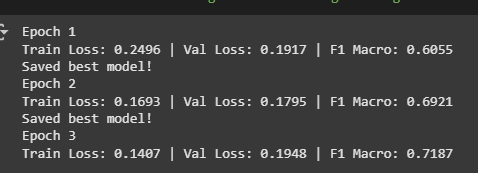

In [ ]:
# Validation loss decreased in second epoch, but again raised in third epoch which means overfitting, only 2 epochs is enough
# On the other hand, F1 improved good.

In [81]:
# Save model
torch.save(model.state_dict(), 'toxic_comment_classifier.pth')

# Download the saved model
files.download('toxic_comment_classifier.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>